In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
import requests
import json
from mlProject.utils.ura_token import ura_token
from pandas import json_normalize
import psycopg2
import uuid
import pandas.io.sql as psql


In [3]:
from datetime import datetime
import json
from dotenv import load_dotenv
import os

# Load environment variables from the .env file (if present)


In [4]:
def get_dataframe_from_sql(table_name: str, conn_params: dict):
    connection = psycopg2.connect(**conn_params)
    cursor = connection.cursor()
    df = psql.read_sql(f"Select * from {table_name}", connection)
    return df

In [5]:
# Connect to PostgreSQL
load_dotenv()

database = os.getenv('database')
dbuser = os.getenv('dbuser')
dbpassword = os.getenv('dbpassword')

conn_params = {
    "host":"localhost",
    "database":database,
    "user":dbuser,
    "password":dbpassword

}

table_name = "propertypricetable"
df_fetch = get_dataframe_from_sql(table_name, conn_params)
df_fetch.head()

,id,area,floor_range,no_of_units,contract_date,type_of_sale,price,property_type,district,type_of_area,tenure,nett_price,project,street,market_segment,x,y
0,bd8e964b-8b01-45ca-9cd5-d5810b9588d4,159.3,-,1,2020-03-01,3,2630000.0,Terrace,05,Land,Freehold,NaN,LANDED HOUSING DEVELOPMENT,NEO PEE TECK LANE,RCR,20914.198897,30589.107079
1,54d728f7-df61-42fc-ab22-f7ef08bbe7dd,186.0,-,1,2021-03-01,3,1880000.0,Strata Terrace,05,Strata,Freehold,NaN,LANDED HOUSING DEVELOPMENT,NEO PEE TECK LANE,RCR,20914.198897,30589.107079
2,b5190668-75e4-49e5-9fc4-81b504d8d35a,257.0,-,1,2022-05-01,3,4600000.0,Terrace,05,Land,Freehold,NaN,LANDED HOUSING DEVELOPMENT,NEO PEE TECK LANE,RCR,20914.198897,30589.107079
3,d46fe197-3c71-4278-83ed-51bb2816db8e,524.3,-,1,2020-02-01,3,5500000.0,Semi-detached,05,Land,Freehold,NaN,LANDED HOUSING DEVELOPMENT,ZEHNDER ROAD,RCR,NaN,NaN
4,a825db95-5239-4bd9-8e19-f21bb265d42b,308.0,-,1,2021-09-01,3,5200000.0,Semi-detached,05,Land,Freehold,NaN,LANDED HOUSING DEVELOPMENT,ZEHNDER ROAD,RCR,NaN,NaN


connection = psycopg2.connect(**conn_params)
cursor = connection.cursor()
cursor.execute("""SELECT table_name FROM information_schema.tables
       WHERE table_schema = 'public'""")
for table in cursor.fetchall():
    print(table)
cursor.close()
connection.close()

In [6]:
df_fetch.dtypes.to_dict()

{'id': dtype('O'),
 'area': dtype('float64'),
 'floor_range': dtype('O'),
 'no_of_units': dtype('int64'),
 'contract_date': dtype('<M8[ns]'),
 'type_of_sale': dtype('O'),
 'price': dtype('float64'),
 'property_type': dtype('O'),
 'district': dtype('O'),
 'type_of_area': dtype('O'),
 'tenure': dtype('O'),
 'nett_price': dtype('float64'),
 'project': dtype('O'),
 'street': dtype('O'),
 'market_segment': dtype('O'),
 'x': dtype('float64'),
 'y': dtype('float64')}

In [7]:
df_fetch.to_csv(f'../data/raw/{table_name}.csv',index=False)

In [8]:
#df_fetch = pd.read_csv(f'../data/raw/{table_name}.csv',parse_dates=['contract_date'])

In [9]:
df_ec = df_fetch.loc[(df_fetch['property_type']=='Executive Condominium')].sort_values(by=['contract_date'])#&(df_fetch['type_of_sale']=='3')

In [10]:
df_ec.head(2)

,id,area,floor_range,no_of_units,contract_date,type_of_sale,price,property_type,district,type_of_area,tenure,nett_price,project,street,market_segment,x,y
77162,870ae034-8a35-475f-9426-b2f37dada9e6,140.0,06-10,1,2019-08-01,1,1636800.0,Executive Condominium,19,Strata,99 yrs lease commencing from 2018,NaN,PIERMONT GRAND,SUMANG WALK,OCR,35168.0772,43541.40613
77161,6568a8d9-b589-4e9a-aef8-2223b805644a,127.0,06-10,1,2019-08-01,1,1420800.0,Executive Condominium,19,Strata,99 yrs lease commencing from 2018,NaN,PIERMONT GRAND,SUMANG WALK,OCR,35168.0772,43541.40613


In [11]:
df_fetch.floor_range.unique()

array(['-', '01-05', '06-10', '21-25', '31-35', '41-45', '16-20', '36-40',
       '26-30', '11-15', '56-60', '46-50', '51-55', 'B1-B5', '61-65',
       '66-70', '71-75'], dtype=object)

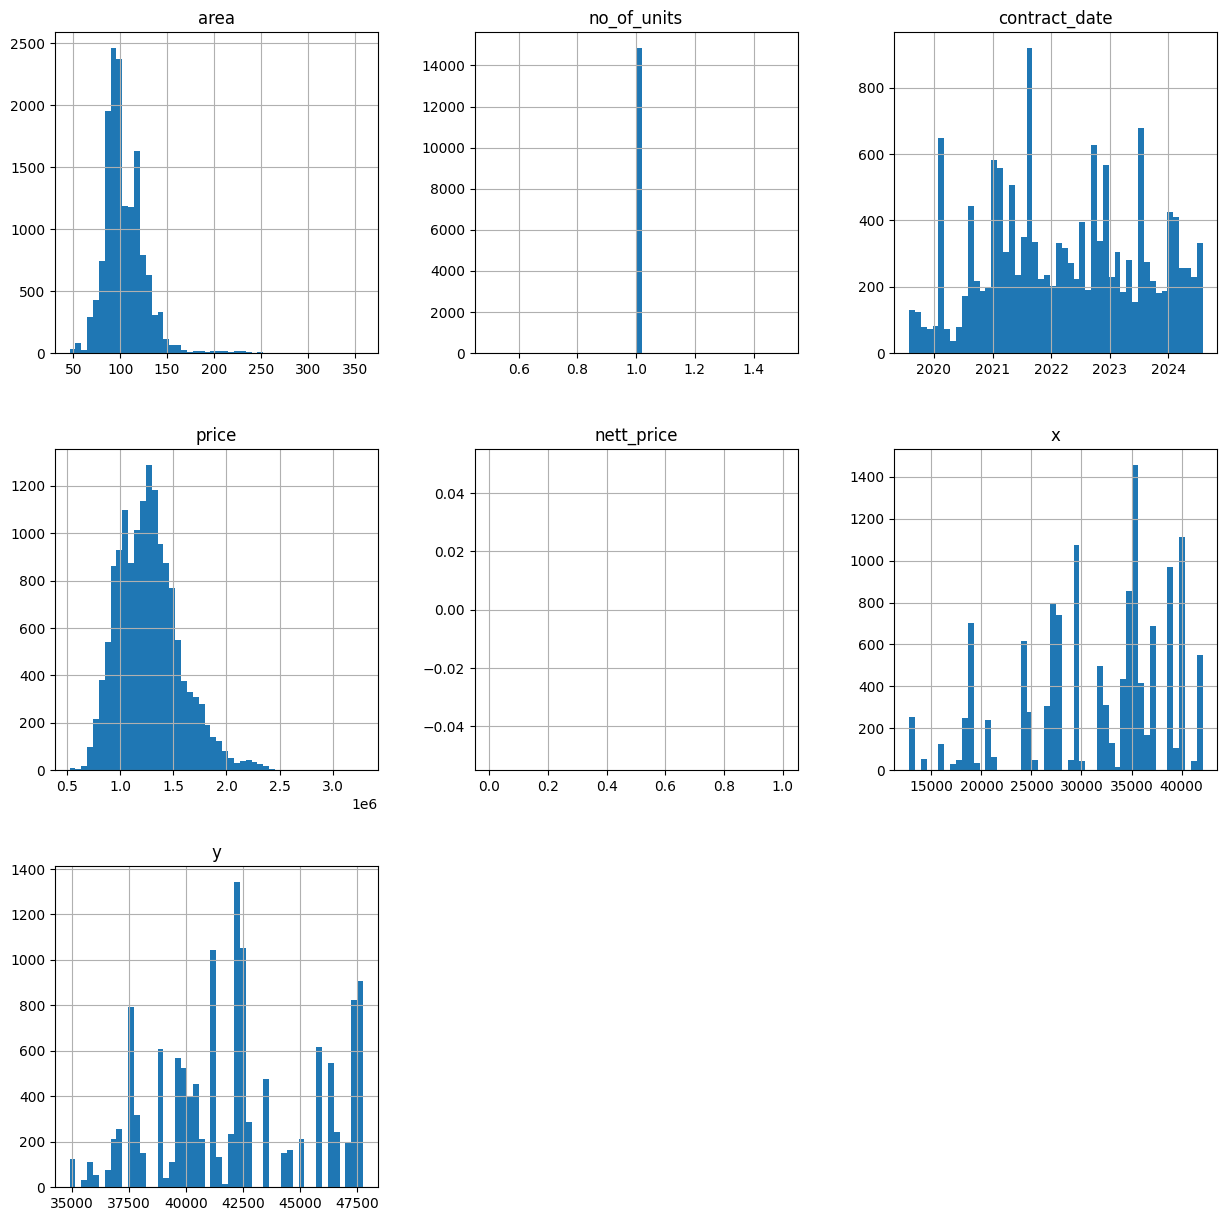

In [12]:
df_ec.hist(bins=50, figsize=(15, 15))
plt.show()

In [13]:
df_ec['type_of_area'].unique()

array(['Strata'], dtype=object)

In [14]:
df_ec['market_segment'].unique()

array(['OCR', 'RCR'], dtype=object)

In [15]:
def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month



In [16]:
df_ec['tenure_start'] = df_ec['tenure'].apply(lambda x: int(x.split(' ')[-1]))
#print(df_ec['tenure_start'].unique())
df_ec['year_after_lease_com'] = df_ec['contract_date'].dt.year - df_ec['tenure_start']
df_ec['year_after_lease_com'] = df_ec['year_after_lease_com'].astype(int)
df_ec['contract_month'] = df_ec['contract_date'].dt.month
#df_ec['contract_date_month'] = df_ec['contract_date'].apply(lambda x: diff_month(x, datetime(2019,8,1)))
floor_range = sorted(df_ec['floor_range'].unique())
level = range(1,len(floor_range)+1)
map_dict = dict(zip(floor_range, level))
df_ec.replace({"floor_range": map_dict},inplace=True)

df_ec['price_sqft'] = df_ec['price']/df_ec['area']
df_ec['district'] = df_ec['district'].astype(int)
df_ec.head()

,id,area,floor_range,no_of_units,contract_date,type_of_sale,price,property_type,district,type_of_area,...,nett_price,project,street,market_segment,x,y,tenure_start,year_after_lease_com,contract_month,price_sqft
77162,870ae034-8a35-475f-9426-b2f37dada9e6,140.0,2,1,2019-08-01,1,1636800.0,Executive Condominium,19,Strata,...,NaN,PIERMONT GRAND,SUMANG WALK,OCR,35168.0772,43541.40613,2018,1,8,11691.428571
77161,6568a8d9-b589-4e9a-aef8-2223b805644a,127.0,2,1,2019-08-01,1,1420800.0,Executive Condominium,19,Strata,...,NaN,PIERMONT GRAND,SUMANG WALK,OCR,35168.0772,43541.40613,2018,1,8,11187.401575
77207,dbf5b06f-139a-4b8a-b49f-ccd729423c1a,92.0,1,1,2019-08-01,1,1028000.0,Executive Condominium,19,Strata,...,NaN,PIERMONT GRAND,SUMANG WALK,OCR,35168.0772,43541.40613,2018,1,8,11173.913043
77132,1017602d-13c5-436e-867c-c720d7d87ab3,97.0,3,1,2019-08-01,1,1072000.0,Executive Condominium,19,Strata,...,NaN,PIERMONT GRAND,SUMANG WALK,OCR,35168.0772,43541.40613,2018,1,8,11051.546392
77138,35017259-9b61-4dcc-ab82-7f762ce44a49,90.0,2,1,2019-08-01,1,1051500.0,Executive Condominium,19,Strata,...,NaN,PIERMONT GRAND,SUMANG WALK,OCR,35168.0772,43541.40613,2018,1,8,11683.333333


In [17]:
columns_to_drop = ['no_of_units','type_of_area','nett_price','property_type','id','tenure_start']#,'type_of_sale'
df_ec.drop(columns=columns_to_drop,inplace=True)

In [18]:
#
print([feature for feature in df_ec.columns if df_ec[feature].dtype != 'O'])
numeric_features = ['price','area','price_sqft','contract_date','floor_range','district','x','y','year_after_lease_com','contract_month']

['area', 'floor_range', 'contract_date', 'price', 'district', 'x', 'y', 'year_after_lease_com', 'contract_month', 'price_sqft']


#### Investigate type of sale according to years after commencement 

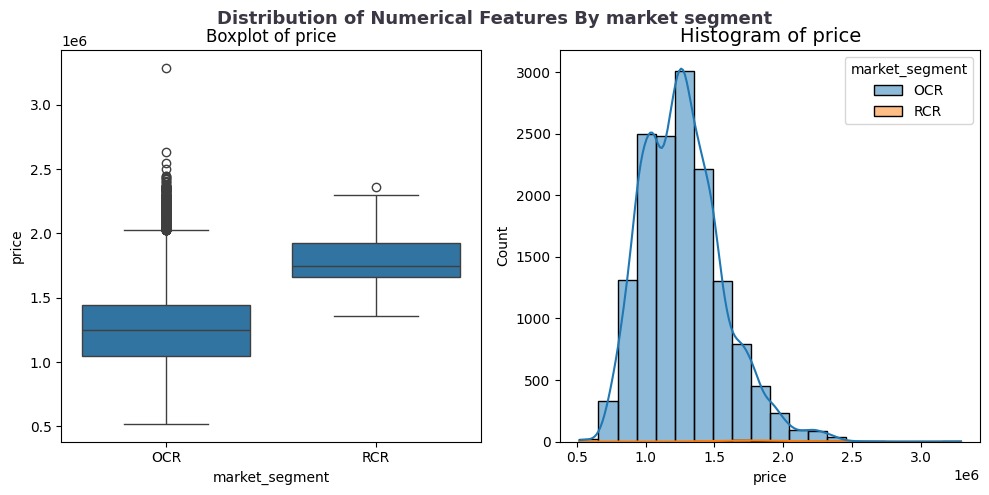

In [19]:

col = 'price'

fig, ax = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Distribution of Numerical Features By market segment', color='#3C3744',fontsize=13, fontweight='bold', ha='center') 
sns.boxplot(data=df_ec, x='market_segment', y=col, ax=ax[0])
ax[0].set_title(f'Boxplot of {col}', fontsize=12)
sns.histplot(data=df_ec, x=col, hue='market_segment', bins=20, kde=True, multiple='stack', ax=ax[1])
ax[1].set_title(f'Histogram of {col}', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.90)
# plt.savefig('images/multivariate_num.png')

<Axes: xlabel='year_after_lease_com'>

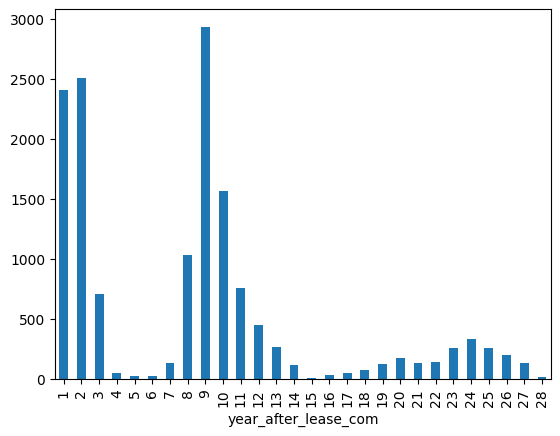

In [20]:
df_ec_year_after_lease_com = df_ec['year_after_lease_com'].value_counts().sort_index()
df_ec_year_after_lease_com.plot.bar()

<Axes: xlabel='year_after_lease_com'>

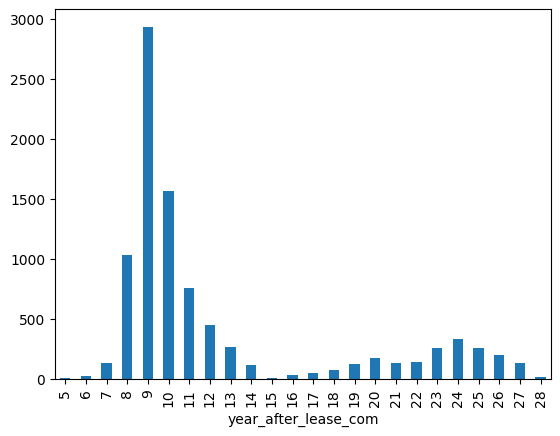

In [21]:
df_ec.loc[df_ec['type_of_sale']=='3','year_after_lease_com'].value_counts().sort_index().plot.bar()

<Axes: xlabel='year_after_lease_com'>

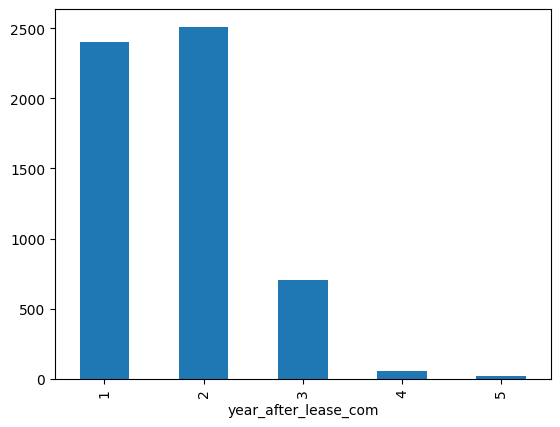

In [22]:
df_ec.loc[df_ec['type_of_sale']!='3','year_after_lease_com'].value_counts().sort_index().plot.bar()

In [23]:
df_ec_year_after_lease_com.to_frame().reset_index().describe()

,year_after_lease_com,count
count,28.000000,28.000000
mean,14.500000,531.071429
std,8.225975,817.912289
min,1.000000,4.000000
25%,7.750000,69.250000
50%,14.500000,156.500000
75%,21.250000,515.000000
max,28.000000,2934.000000


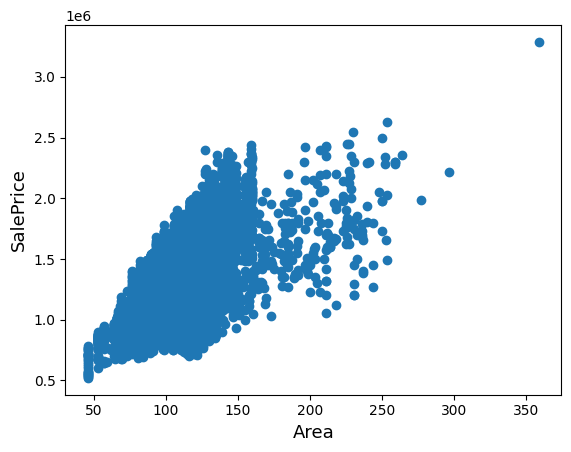

In [24]:
fig, ax = plt.subplots()
ax.scatter(x = df_ec['area'], y = df_ec['price'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('Area', fontsize=13)
plt.show()

#### We can see one transaction with very large area and high price  

In [25]:
from scipy.stats import norm, skew #for some statistics
from scipy import stats



 mu = 1271758.24 and sigma = 293415.12


 mu = 14.03 and sigma = 0.23



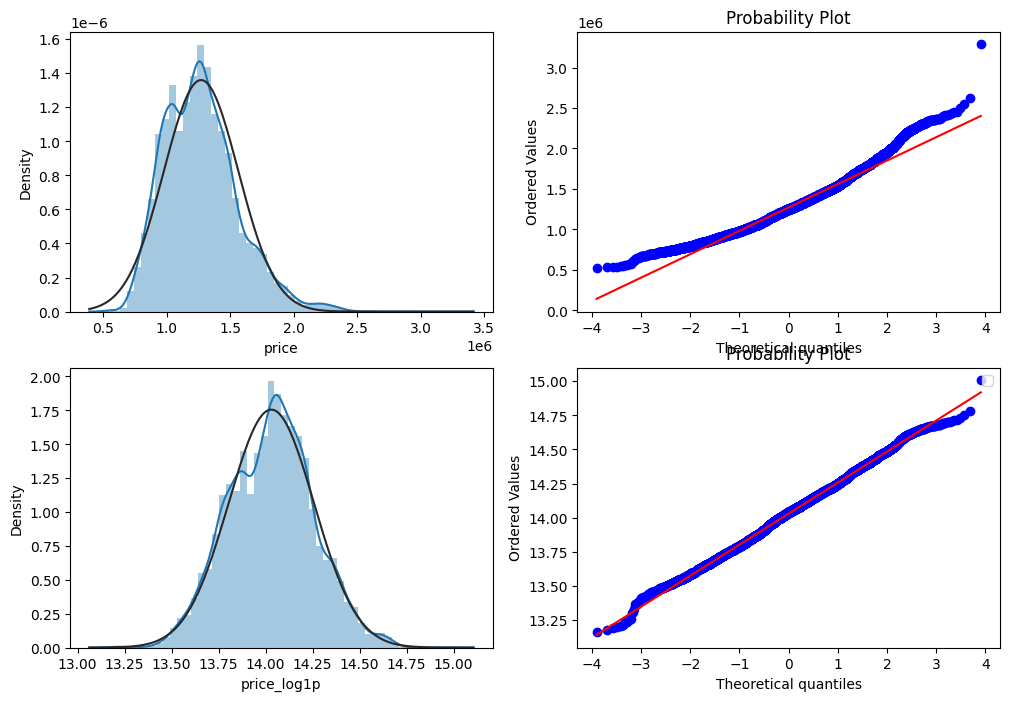


 mu = 104.21 and sigma = 22.18


 mu = 4.64 and sigma = 0.20



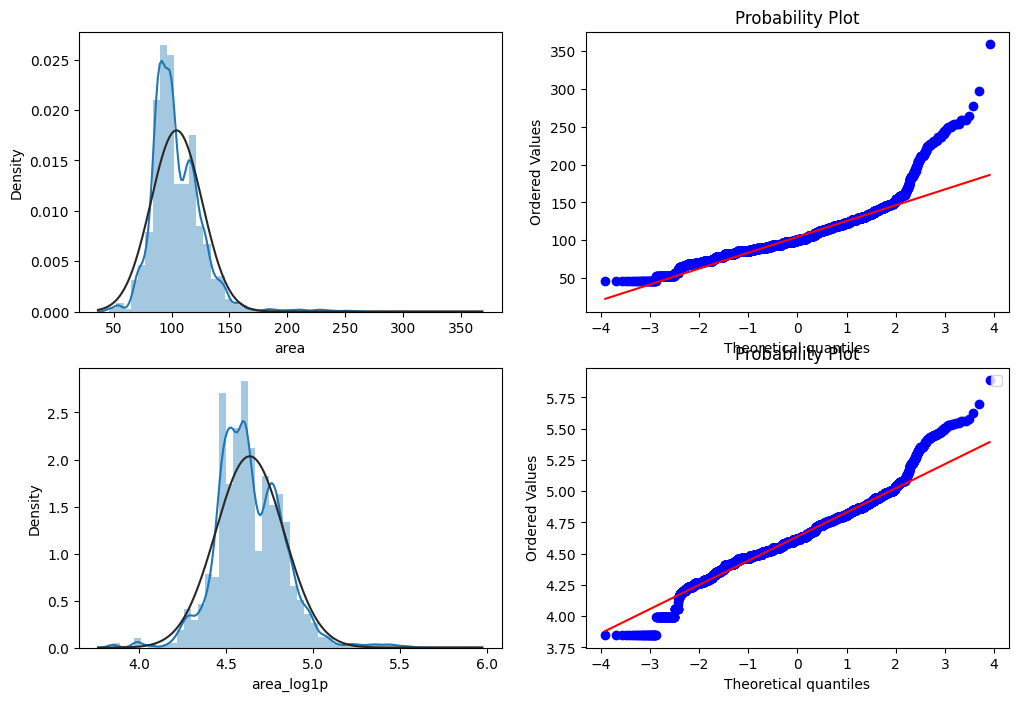


 mu = 12363.12 and sigma = 2270.25


 mu = 9.40 and sigma = 0.20



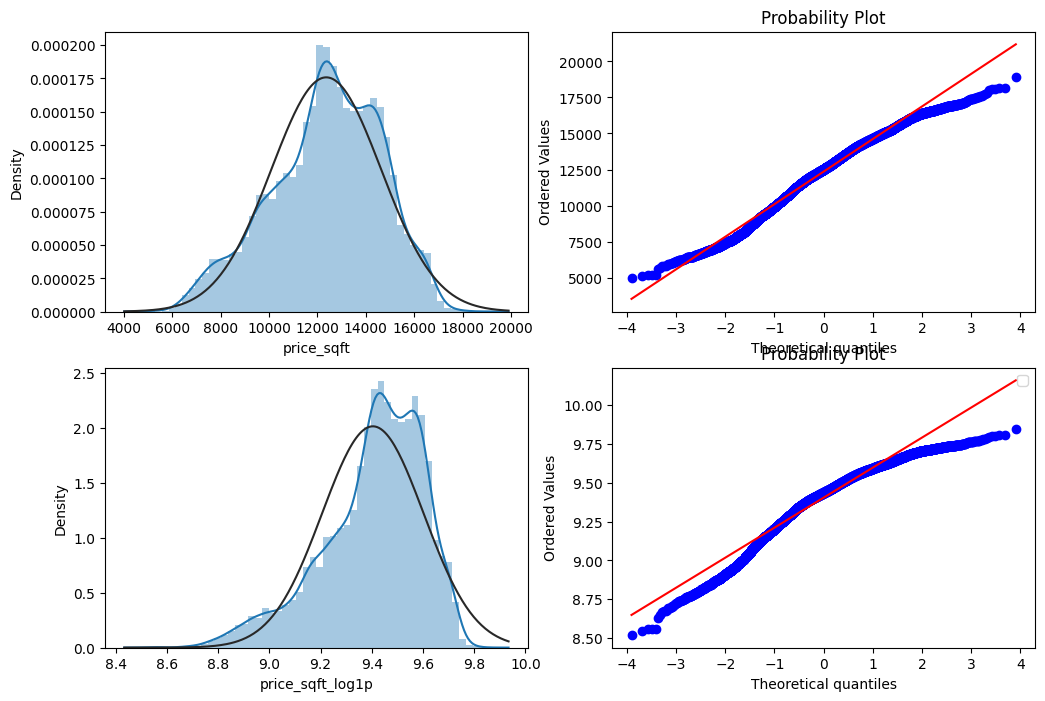

In [26]:
def plot_distribution_qq_plot(df_ec,col):
    #We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
    fig,ax = plt.subplots(2,2,figsize=(12,8))

    sns.distplot(df_ec[col] , fit=norm,ax=ax[0,0]);

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(df_ec[col])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

    #Now plot the distribution
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title(f'{col} distribution')

    #Get also the QQ-plot
    #fig = plt.figure()
    res = stats.probplot(df_ec[col], plot=ax[0,1])

    df_ec[f"{col}_log1p"] = np.log1p(df_ec[col])

    sns.distplot(df_ec[f'{col}_log1p'] , fit=norm,ax=ax[1,0]);

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(df_ec[f'{col}_log1p'])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

    #Now plot the distribution
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title(f'{col} distribution')

    #Get also the QQ-plot
    #fig = plt.figure()
    res = stats.probplot(df_ec[f'{col}_log1p'], plot=ax[1,1])
    plt.show()

plot_distribution_qq_plot(df_ec,'price')
plot_distribution_qq_plot(df_ec,'area')
plot_distribution_qq_plot(df_ec,'price_sqft')

#### The target variable is right skewed. As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.

#### The skew seems now corrected and the data appears more normally distributed.

In [27]:
df_ec["price_log1p"] = np.log1p(df_ec['price'])

### Missing Data

In [28]:
all_data_na = (df_ec.isnull().sum() / len(df_ec)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio
x,9.26698
y,9.26698


In [29]:
df_null = df_ec[df_ec.isnull().any(axis=1)]
df_null['type_of_sale'].unique()

array(['1'], dtype=object)

In [30]:
df_ec_num = df_ec[numeric_features]
pear_corr=df_ec_num.corr(method='pearson')
display(pear_corr['price'].sort_values(ascending=False).to_frame().style.background_gradient(cmap='Greens', axis=0))
display(pear_corr.style.background_gradient(cmap='Greens', axis=0))

,price
price,1.000000
area,0.573784
price_sqft,0.560798
contract_date,0.470905
x,0.144020
floor_range,0.098998
contract_month,0.017846
district,-0.034491
y,-0.070296
year_after_lease_com,-0.249420


,price,area,price_sqft,contract_date,floor_range,district,x,y,year_after_lease_com,contract_month
price,1.000000,0.573784,0.560798,0.470905,0.098998,-0.034491,0.144020,-0.070296,-0.249420,0.017846
area,0.573784,1.000000,-0.328658,-0.045351,0.062996,-0.090438,0.018060,-0.079596,0.312090,0.038441
price_sqft,0.560798,-0.328658,1.000000,0.632575,0.078003,0.064285,0.108160,0.002096,-0.585169,-0.015540
contract_date,0.470905,-0.045351,0.632575,1.000000,-0.006073,0.129822,-0.140034,0.029523,0.079057,0.038659
floor_range,0.098998,0.062996,0.078003,-0.006073,1.000000,-0.052306,-0.063752,-0.130608,0.035076,0.016185
district,-0.034491,-0.090438,0.064285,0.129822,-0.052306,1.000000,-0.604295,0.673879,-0.137966,0.004833
x,0.144020,0.018060,0.108160,-0.140034,-0.063752,-0.604295,1.000000,-0.299613,-0.222458,0.016458
y,-0.070296,-0.079596,0.002096,0.029523,-0.130608,0.673879,-0.299613,1.000000,-0.173766,-0.018323
year_after_lease_com,-0.249420,0.312090,-0.585169,0.079057,0.035076,-0.137966,-0.222458,-0.173766,1.000000,-0.003339
contract_month,0.017846,0.038441,-0.015540,0.038659,0.016185,0.004833,0.016458,-0.018323,-0.003339,1.000000


In [31]:

df_ec_resale = df_ec[df_ec['type_of_sale']=='3'].drop(columns=['type_of_sale'])
df_ec_num = df_ec_resale[numeric_features]
pear_corr=df_ec_num.corr(method='pearson')
display(pear_corr.style.background_gradient(cmap='Greens', axis=0))
display(pear_corr['price'].sort_values(ascending=False).to_frame().style.background_gradient(cmap='Greens', axis=0))


,price,area,price_sqft,contract_date,floor_range,district,x,y,year_after_lease_com,contract_month
price,1.000000,0.561635,0.507549,0.503093,0.125169,-0.066256,0.090095,-0.022713,-0.127405,-0.014951
area,0.561635,1.000000,-0.397185,-0.125634,0.041179,-0.070110,0.035650,-0.042520,0.352277,0.031909
price_sqft,0.507549,-0.397185,1.000000,0.727896,0.132647,0.021234,0.013256,0.020960,-0.490395,-0.052801
contract_date,0.503093,-0.125634,0.727896,1.000000,-0.007290,0.146582,-0.143313,0.123846,0.007032,-0.085986
floor_range,0.125169,0.041179,0.132647,-0.007290,1.000000,-0.007677,-0.095175,-0.126933,-0.025747,0.001602
district,-0.066256,-0.070110,0.021234,0.146582,-0.007677,1.000000,-0.592477,0.629234,-0.094946,-0.012761
x,0.090095,0.035650,0.013256,-0.143313,-0.095175,-0.592477,1.000000,-0.160644,-0.115766,0.017172
y,-0.022713,-0.042520,0.020960,0.123846,-0.126933,0.629234,-0.160644,1.000000,-0.179831,0.025447
year_after_lease_com,-0.127405,0.352277,-0.490395,0.007032,-0.025747,-0.094946,-0.115766,-0.179831,1.000000,-0.046361
contract_month,-0.014951,0.031909,-0.052801,-0.085986,0.001602,-0.012761,0.017172,0.025447,-0.046361,1.000000


,price
price,1.000000
area,0.561635
price_sqft,0.507549
contract_date,0.503093
floor_range,0.125169
x,0.090095
contract_month,-0.014951
y,-0.022713
district,-0.066256
year_after_lease_com,-0.127405


In [32]:
df_ec['district'].value_counts()

district
19    4048
27    2917
18    2777
23    2070
25     942
28     922
24     639
22     461
20      94
Name: count, dtype: int64

<Axes: title={'center': 'Price vs Date'}, xlabel='Years', ylabel='House Price'>

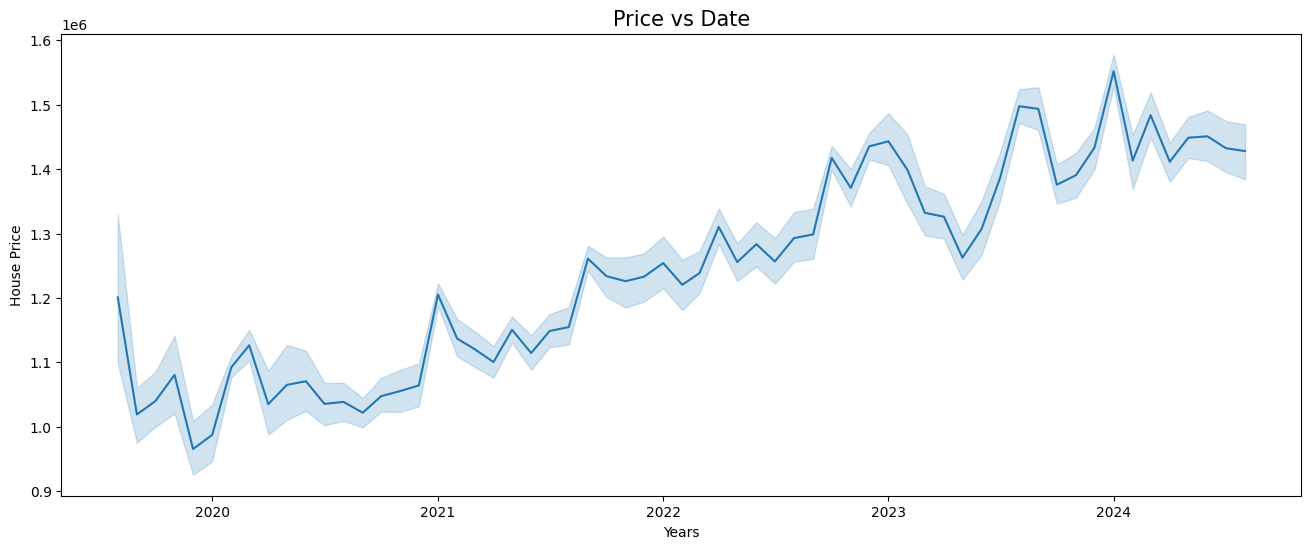

In [33]:
fig, ax1 = plt.subplots(figsize=(16, 6))
#ax2 = ax1.twinx()
palette = sns.color_palette("flare", as_cmap=True)
plt.title('Price vs Date', fontdict={'fontsize': 15}), plt.xlabel('Years'), plt.ylabel('House Price')
sns.lineplot(data=df_ec,x='contract_date', y='price',ax=ax1)




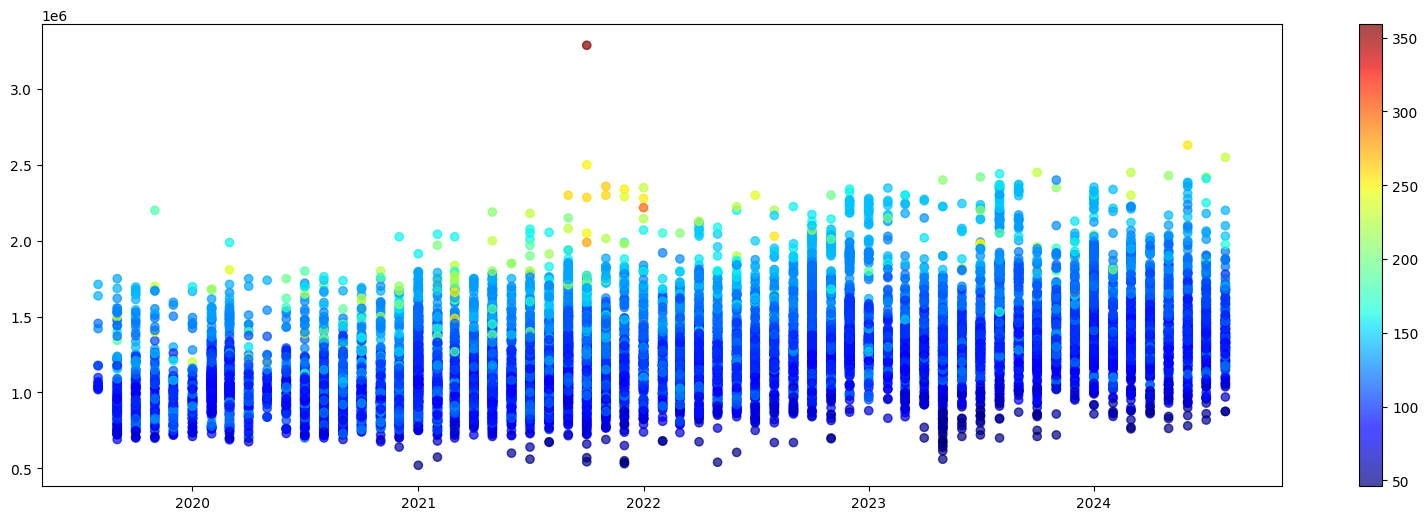

In [34]:
fig, ax = plt.subplots(figsize=(20, 6))
g = ax.scatter(df_ec['contract_date'],df_ec['price'], c=df_ec['area'], cmap=plt.get_cmap("jet"), alpha=0.7)
fig.colorbar(g)

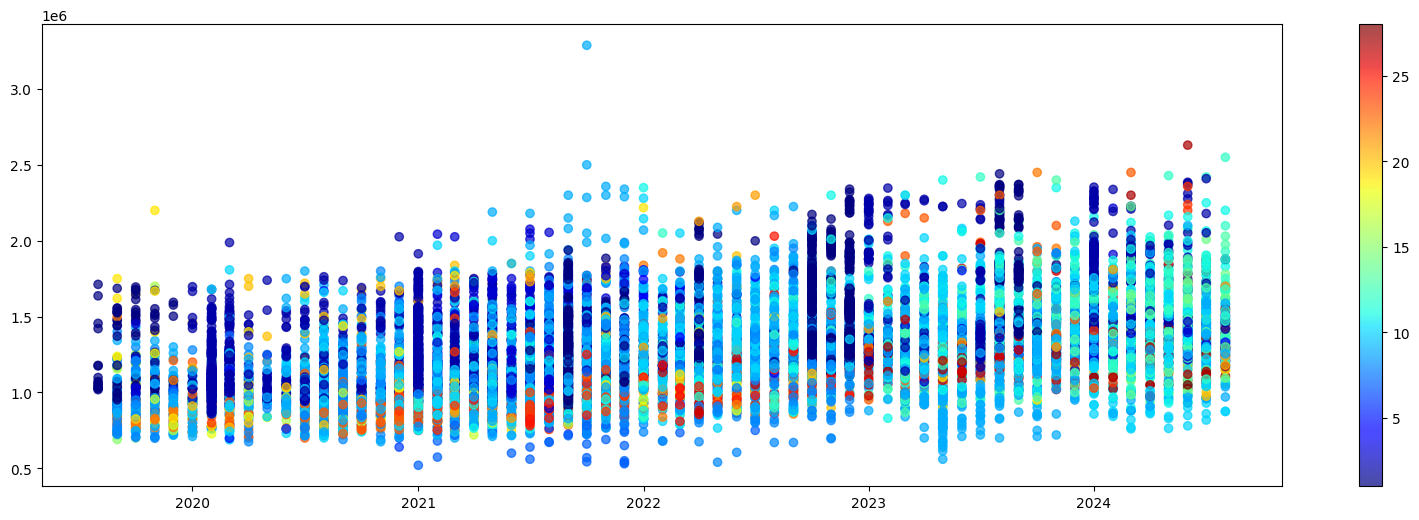

In [35]:
fig, ax = plt.subplots(figsize=(20, 6))
g = ax.scatter(df_ec['contract_date'],df_ec['price'], c=df_ec['year_after_lease_com'], cmap=plt.get_cmap("jet"), alpha=0.7)
fig.colorbar(g)

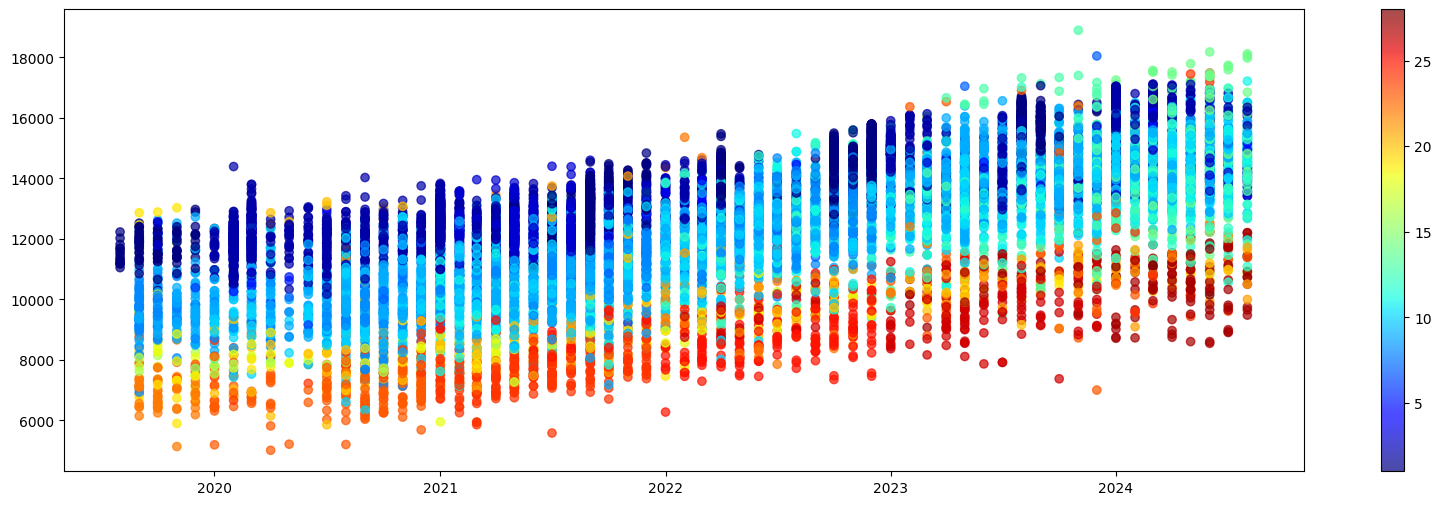

In [36]:
fig, ax = plt.subplots(figsize=(20, 6))
g = ax.scatter(df_ec['contract_date'],df_ec['price_sqft'], c=df_ec['year_after_lease_com'], cmap=plt.get_cmap("jet"), alpha=0.7)
fig.colorbar(g)

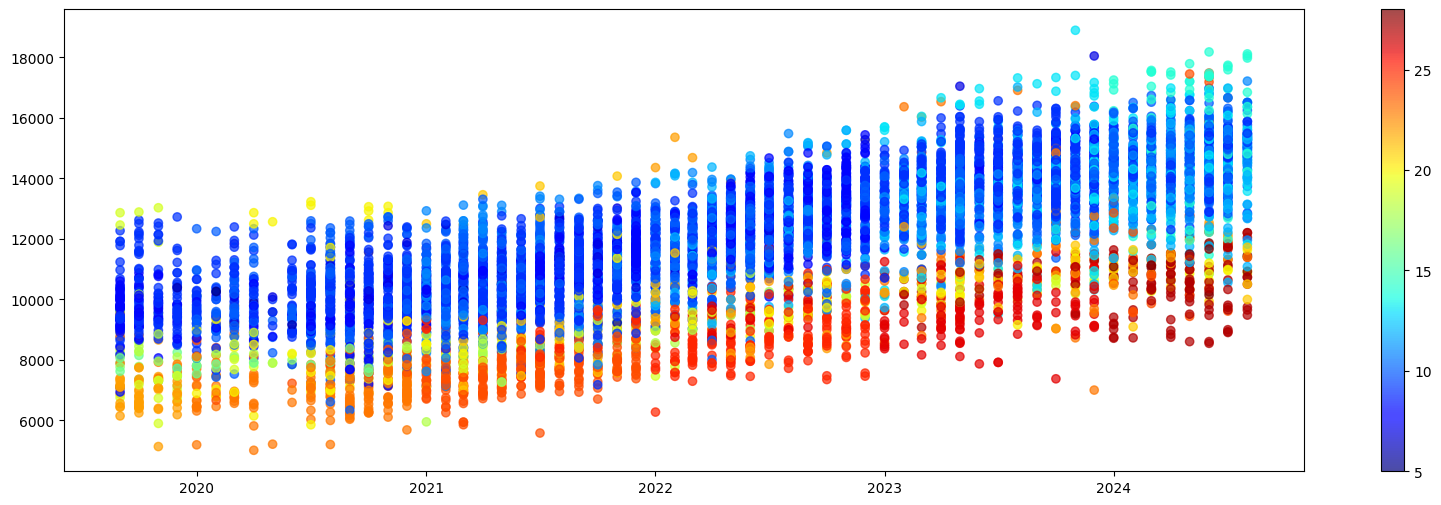

In [37]:
fig, ax = plt.subplots(figsize=(20, 6))
g = ax.scatter(df_ec_resale['contract_date'],df_ec_resale['price_sqft'], c=df_ec_resale['year_after_lease_com'], cmap=plt.get_cmap("jet"), alpha=0.7)
fig.colorbar(g)

fig, ax2 = plt.subplots(figsize=(16, 6))
amount_by_date = df_ec['contract_date'].value_counts().to_frame().reset_index().sort_values(by=['contract_date'])
plt.title('Sale Amount vs Date', fontdict={'fontsize': 15}), plt.xlabel('Years'), plt.ylabel('House Price')
sns.lineplot(data=amount_by_date,x='contract_date', y='count', label='House Price',ax=ax2)

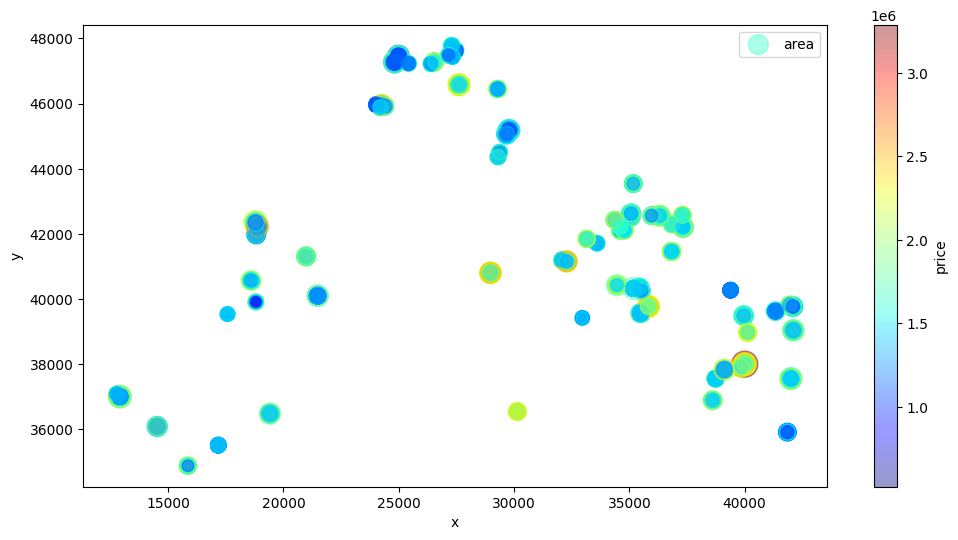

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))
df_ec.plot(kind="scatter", x="x", y="y", alpha=0.4,
            s=df_ec["area"], label="area",
            c="price", cmap=plt.get_cmap("jet"), colorbar=True,ax=ax)
plt.legend()

import requests

load_dotenv()
onemap_token = os.getenv('onemap_token')
df_projec_null = pd.DataFrame()
for name in df_null['project'].unique():

    new_name = name.replace(' ','%20')
    url = f"https://www.onemap.gov.sg/api/common/elastic/search?searchVal={new_name}&returnGeom=Y&getAddrDetails=Y&pageNum=1"
    headers = {"Authorization": onemap_token}     
    response = requests.request("GET", url, headers=headers)
      
    results = response.json()['results']
    print(results[0])
    df_ec.loc[df_ec['project']==name,'x'] = results[0]['X']
    df_ec.loc[df_ec['project']==name,'y'] = results[0]['Y']

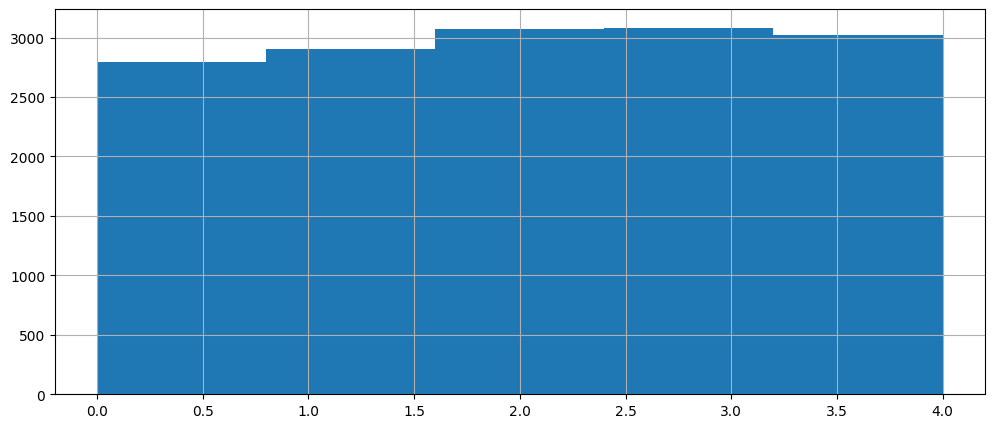

In [39]:
from sklearn.preprocessing import KBinsDiscretizer
n_bins = 5
enc = KBinsDiscretizer(n_bins=n_bins, encode="ordinal", strategy='quantile')#'uniform', 'kmeans', 'quantile'
df_ec['area_bin'] = enc.fit_transform(df_ec['area'].values.reshape(-1,1)).reshape(-1,)
df_ec['area_bin'].hist(bins=n_bins, figsize=(12, 5))
plt.show()

In [40]:
import joblib
scaler_filename = "KBinsDiscretizer.save"
joblib.dump(enc, scaler_filename) 

# And now to load...

scaler = joblib.load(scaler_filename) 


In [41]:
scaler.transform([[100]])[0][0]

2.0

In [42]:
numeric_features = ['price','area','area_bin','price_sqft','contract_date','floor_range','district','x','y','year_after_lease_com','contract_month']
df_ec_resale = df_ec[df_ec['type_of_sale']=='3'].drop(columns=['type_of_sale'])
df_ec_num = df_ec_resale[numeric_features]
pear_corr=df_ec_num.corr(method='pearson')
display(pear_corr.style.background_gradient(cmap='Greens', axis=0))
display(pear_corr['price'].sort_values(ascending=False).to_frame().style.background_gradient(cmap='Greens', axis=0))

,price,area,area_bin,price_sqft,contract_date,floor_range,district,x,y,year_after_lease_com,contract_month
price,1.000000,0.561635,0.474926,0.507549,0.503093,0.125169,-0.066256,0.090095,-0.022713,-0.127405,-0.014951
area,0.561635,1.000000,0.821107,-0.397185,-0.125634,0.041179,-0.070110,0.035650,-0.042520,0.352277,0.031909
area_bin,0.474926,0.821107,1.000000,-0.384307,-0.117446,-0.034214,-0.080419,0.007129,-0.056681,0.423588,0.030384
price_sqft,0.507549,-0.397185,-0.384307,1.000000,0.727896,0.132647,0.021234,0.013256,0.020960,-0.490395,-0.052801
contract_date,0.503093,-0.125634,-0.117446,0.727896,1.000000,-0.007290,0.146582,-0.143313,0.123846,0.007032,-0.085986
floor_range,0.125169,0.041179,-0.034214,0.132647,-0.007290,1.000000,-0.007677,-0.095175,-0.126933,-0.025747,0.001602
district,-0.066256,-0.070110,-0.080419,0.021234,0.146582,-0.007677,1.000000,-0.592477,0.629234,-0.094946,-0.012761
x,0.090095,0.035650,0.007129,0.013256,-0.143313,-0.095175,-0.592477,1.000000,-0.160644,-0.115766,0.017172
y,-0.022713,-0.042520,-0.056681,0.020960,0.123846,-0.126933,0.629234,-0.160644,1.000000,-0.179831,0.025447
year_after_lease_com,-0.127405,0.352277,0.423588,-0.490395,0.007032,-0.025747,-0.094946,-0.115766,-0.179831,1.000000,-0.046361


,price
price,1.000000
area,0.561635
price_sqft,0.507549
contract_date,0.503093
area_bin,0.474926
floor_range,0.125169
x,0.090095
contract_month,-0.014951
y,-0.022713
district,-0.066256


In [43]:
df_ec.columns.values

array(['area', 'floor_range', 'contract_date', 'type_of_sale', 'price',
       'district', 'tenure', 'project', 'street', 'market_segment', 'x',
       'y', 'year_after_lease_com', 'contract_month', 'price_sqft',
       'price_log1p', 'area_log1p', 'price_sqft_log1p', 'area_bin'],
      dtype=object)

In [44]:
drop_columns = ['area','tenure','price_log1p', 'area_log1p', 'price_sqft_log1p', 'price_sqft','']
#df_ec = df_ec.drop(columns=drop_columns)

In [45]:
target_cols = ['price','price_sqft']
project_group_cols = ['contract_date','floor_range','area_bin','project']
df_ec_project_mean = df_ec.groupby(project_group_cols)[target_cols].mean().reset_index()

district_group_cols = ['contract_date','floor_range','area_bin','district','year_after_lease_com']
df_ec_district_mean = df_ec.groupby(district_group_cols)[target_cols].mean().reset_index()

area_floor_year_group_cols = ['contract_date','floor_range','area_bin','year_after_lease_com']
area_floor_year_group_cols = df_ec.groupby(district_group_cols)[target_cols].mean().reset_index()

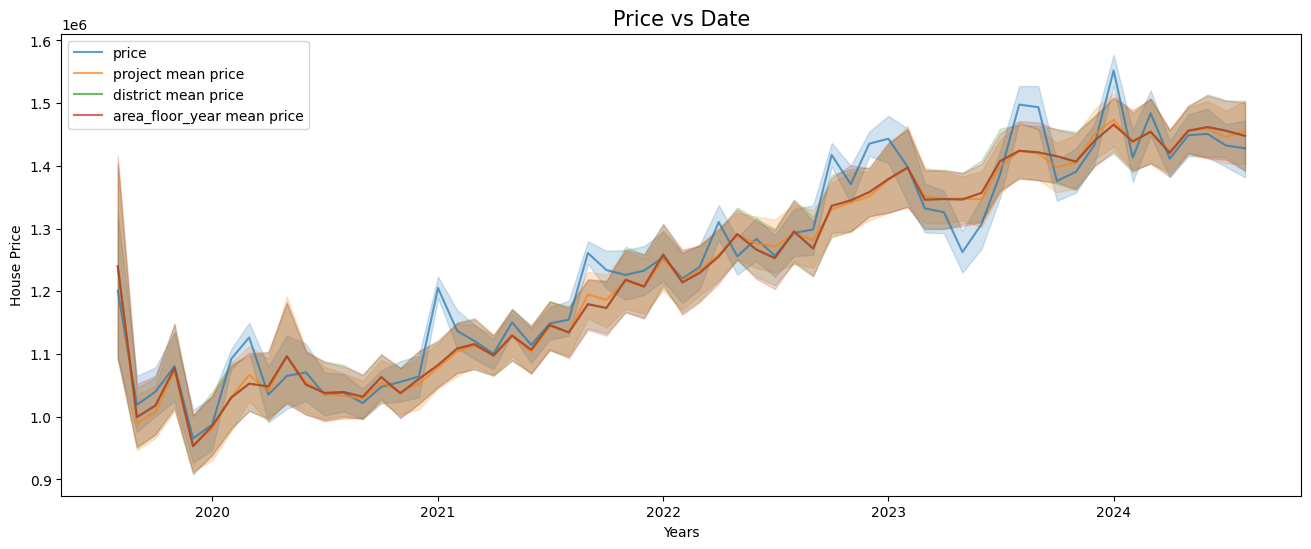

In [46]:
fig, ax = plt.subplots(figsize=(16, 6))
#ax2 = ax1.twinx()
palette = sns.color_palette("flare", as_cmap=True)
plt.title('Price vs Date', fontdict={'fontsize': 15}), plt.xlabel('Years'), plt.ylabel('House Price')
sns.lineplot(data=df_ec,x='contract_date', y='price',ax=ax,label='price', alpha=0.7)
sns.lineplot(data=df_ec_project_mean,x='contract_date', y='price',ax=ax,label='project mean price', alpha=0.7)
#g = ax1.scatter(df_ec['contract_date'],df_ec['price'], c=df_ec['area'], cmap=plt.get_cmap("jet"), alpha=0.7)
sns.lineplot(data=df_ec_district_mean,x='contract_date', y='price',ax=ax,label='district mean price', alpha=0.7)
sns.lineplot(data=area_floor_year_group_cols,x='contract_date', y='price',ax=ax,label='area_floor_year mean price', alpha=0.7)

#df_ec_district_mean.plot(x='contract_date', y='price', label='mean price', ax=ax)
#df_ec.plot(x='contract_date', y='price', label='price', ax=ax)
ax.legend()
plt.legend()
fig.colorbar(g)


In [47]:
#df_ec.drop(columns=['x','y'],inplace=True)

In [48]:
df_ec['area_bin'].unique()

array([4., 1., 2., 3., 0.])

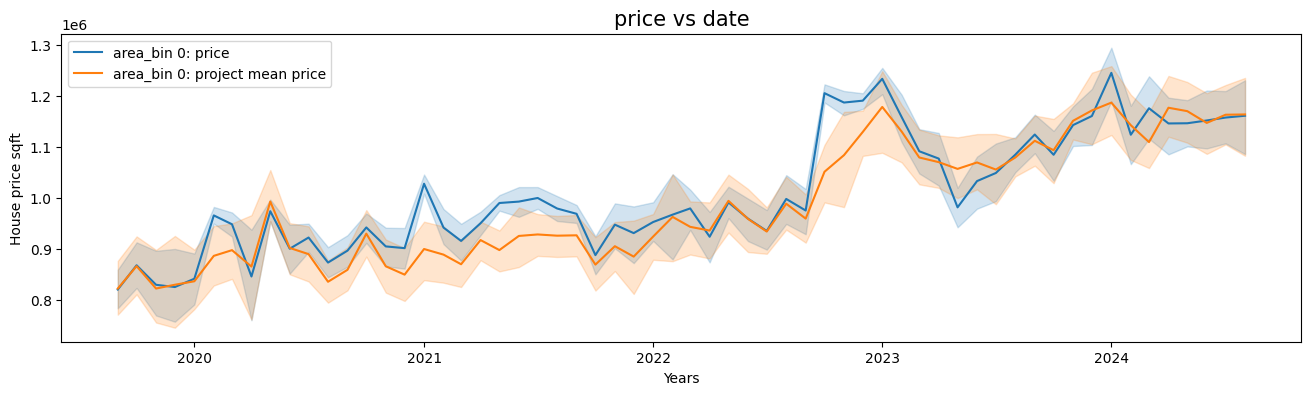

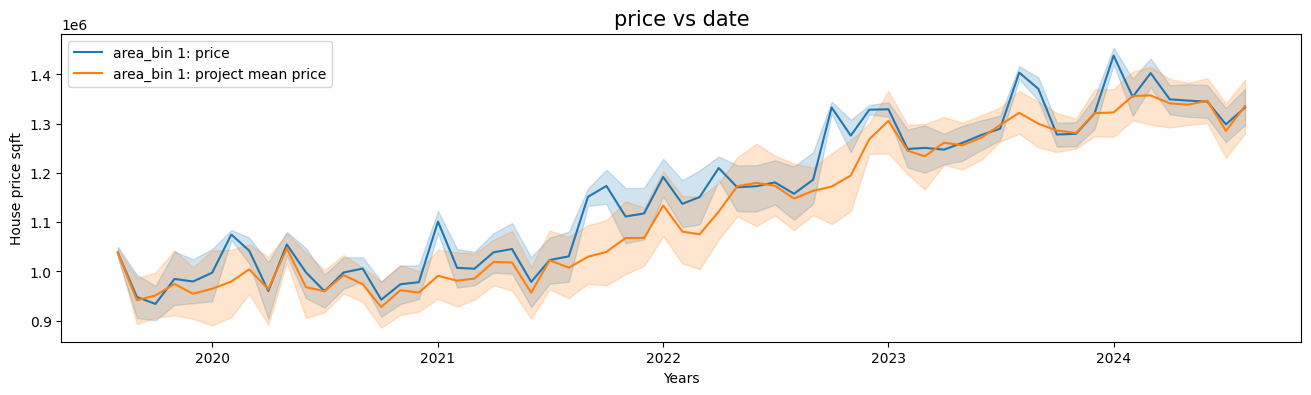

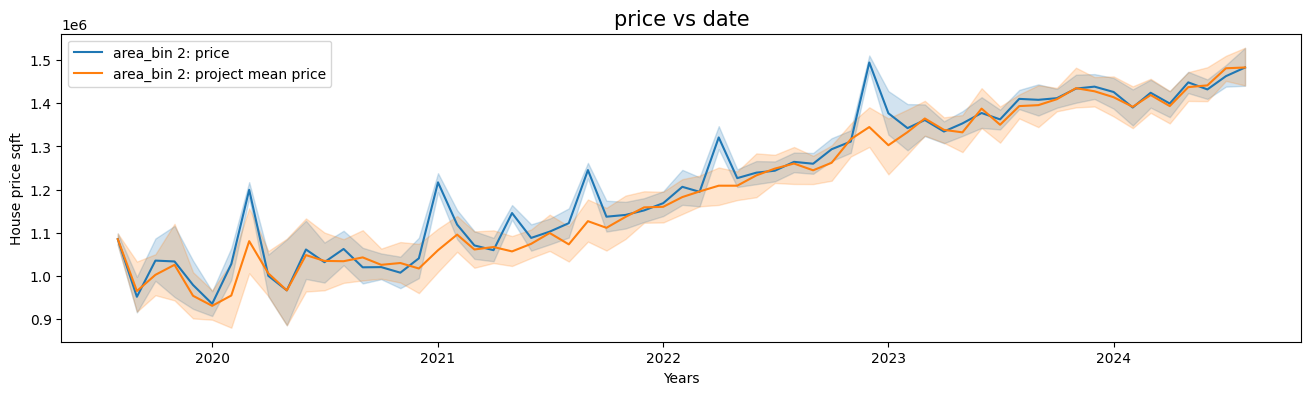

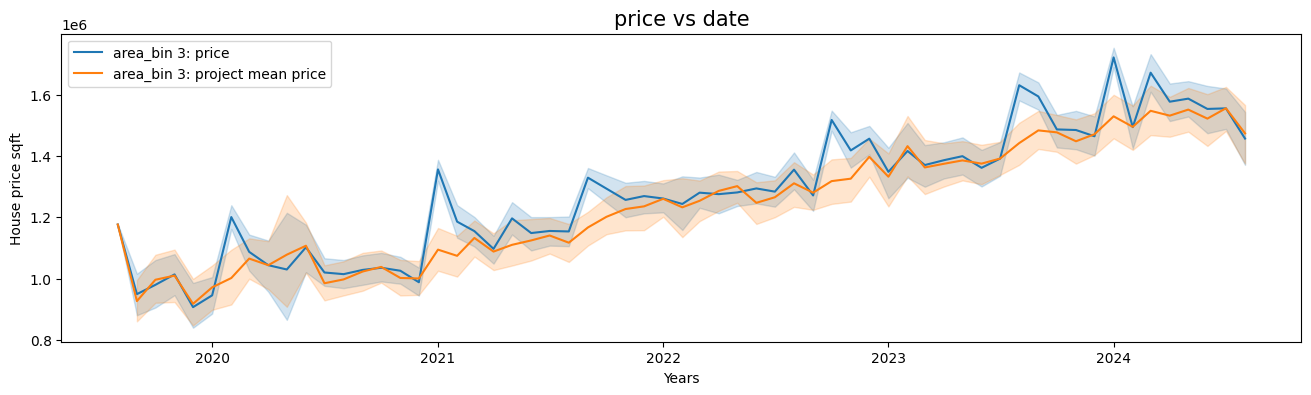

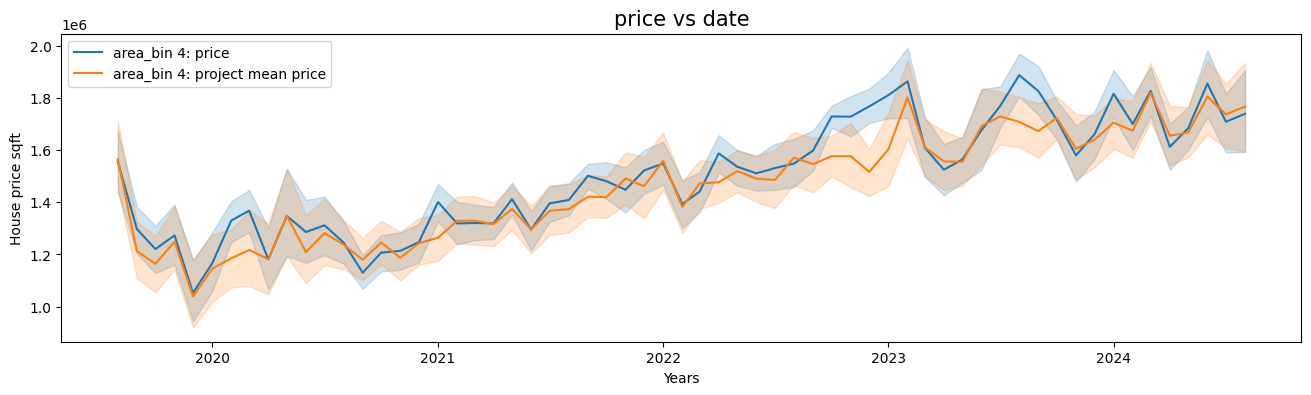

In [49]:
target = 'price'
for area in range(n_bins):
    fig, ax = plt.subplots(figsize=(16, 4))
    #ax2 = ax1.twinx()
    
    palette = sns.color_palette("flare", as_cmap=True)
    plt.title(f'{target} vs date', fontdict={'fontsize': 15}), plt.xlabel('Years'), plt.ylabel('House price sqft')
    #sns.lineplot(data=df_ec,x='contract_date', y=target,ax=ax,label=target)

    #for area in [1]:#range(5):
    sns.lineplot(data=df_ec[(df_ec['area_bin']==area)],x='contract_date', y=target,ax=ax,label=f'area_bin {area}: {target}')
    sns.lineplot(data=area_floor_year_group_cols[area_floor_year_group_cols['area_bin']==area],x='contract_date', y=target,ax=ax,label=f'area_bin {area}: project mean {target}')
    #g = ax1.scatter(df_ec['contract_date'],df_ec['price'], c=df_ec['area'], cmap=plt.get_cmap("jet"), alpha=0.7


    #df_ec_district_mean.plot(x='contract_date', y='price', label='mean price', ax=ax)
    #df_ec.plot(x='contract_date', y='price', label='price', ax=ax)
    ax.legend()
    plt.show()


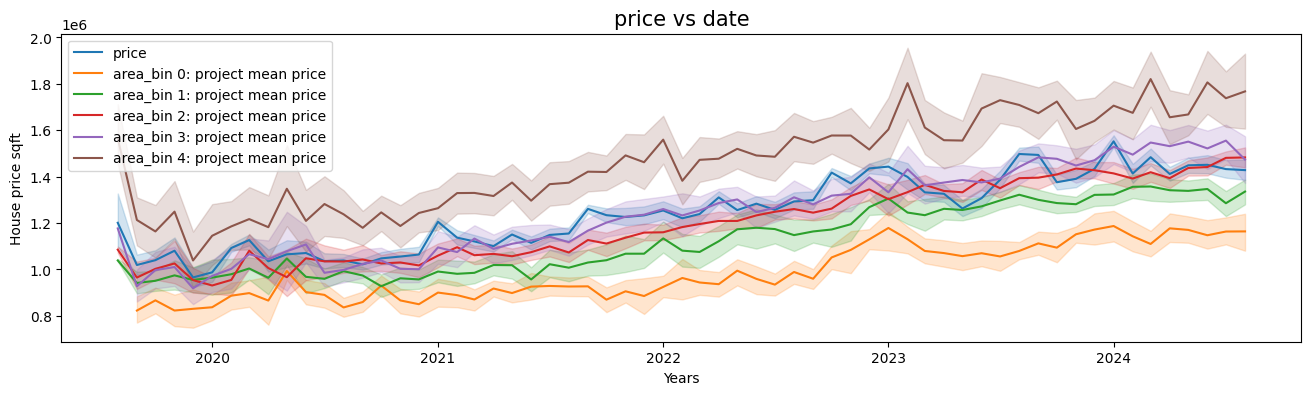

In [50]:

fig, ax = plt.subplots(figsize=(16, 4))
#ax2 = ax1.twinx()
palette = sns.color_palette("flare", as_cmap=True)
plt.title(f'{target} vs date', fontdict={'fontsize': 15}), plt.xlabel('Years'), plt.ylabel('House price sqft')
sns.lineplot(data=df_ec,x='contract_date', y=target,ax=ax,label=target)

for area in range(5):
    #sns.lineplot(data=df_ec[df_ec['area_bin']==area],x='contract_date', y=target,ax=ax,label=f'area_bin {area}: {target}')
    sns.lineplot(data=area_floor_year_group_cols[area_floor_year_group_cols['area_bin']==area],x='contract_date', y=target,ax=ax,label=f'area_bin {area}: project mean {target}')
#g = ax1.scatter(df_ec['contract_date'],df_ec['price'], c=df_ec['area'], cmap=plt.get_cmap("jet"), alpha=0.7


#df_ec_district_mean.plot(x='contract_date', y='price', label='mean price', ax=ax)
#df_ec.plot(x='contract_date', y='price', label='price', ax=ax)
ax.legend()
plt.show()